# Topic Modeling on Movie Scripts Written by Christopher Nolan

In [ ]:
!pip install tika
!pip install pyLDAvis
!pip install bitermplus
!pip install tmplot --upgrade
!pip install gensim --upgrade

  Created wheel for tika: filename=tika-1.24-py3-none-any.whl size=32891 sha256=8c45921436d1f62c7ff2737863980148f256a85613c03dae478398ffb50fb81f
  Stored in directory: /root/.cache/pip/wheels/ec/2b/38/58ff05467a742e32f67f5d0de048fa046e764e2fbb25ac93f3
Successfully built tika
     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.3 MB 21.0 MB/s 
     |████████████████████████████████| 15.7 MB 14.9 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=84baed81f473801d1478f3983a5b210c051c84a6b6bd9a7ea12ed6562be95100
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninst

     |████████████████████████████████| 614 kB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bitermplus: filename=bitermplus-0.6.10-cp37-cp37m-linux_x86_64.whl size=931279 sha256=7810d9c4c0d384e45145c2edfd90e9e122e6558604945c92ea07959781342e85
  Stored in directory: /root/.cache/pip/wheels/2b/1a/8d/58328971ebe27f346b2e0c05ea9fe45bc67986310557074141
Successfully built bitermplus
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 16.3 MB 4.8 MB/s 
  Created wheel for tmplot: filename=tmplot-0.0.5-py3-none-any.whl size=13967 sha256=faf05dceda6df819bec3660f07494b2ceae4505474eaea0023010028eca602f4
  Stored in directory: /root/.cache/pip/wheels/cf/46/a6/f91b4c6750de454081fa0526b4a17850692cb1fe295011c787
Successfully built tmplot
     |████████████████████████████████| 24

In [ ]:
import re
import numpy as np
import pandas as pd
import string
from pprint import pprint
from tika import parser
from collections import Counter

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import models
from gensim.models.nmf import Nmf

import bitermplus as btm

import pyLDAvis
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt
%matplotlib inline
import tmplot as tmp
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python

In [ ]:
# Downloading movie scripts

urls = ['https://www.scriptslug.com/assets/scripts/batman-begins-2005.pdf',
        'https://www.scriptslug.com/assets/scripts/dunkirk-2017.pdf',
        'https://www.scriptslug.com/assets/scripts/following-1998.pdf',
        'https://www.scriptslug.com/assets/scripts/inception-2010.pdf',
        'https://www.scriptslug.com/assets/scripts/interstellar-2014.pdf',
        'https://www.scriptslug.com/assets/scripts/memento-2000.pdf',
        'https://www.scriptslug.com/assets/scripts/tenet-2020.pdf',
        'https://www.scriptslug.com/assets/scripts/the-dark-knight-2008.pdf',
        'https://www.scriptslug.com/assets/scripts/the-dark-knight-rises-2012.pdf',
        'https://www.scriptslug.com/assets/scripts/the-prestige-2006.pdf']

scripts = []
movies = []

for url in urls:
    pdf_contents = parser.from_file(url)
    f = pdf_contents['content']

    spoken_text = ''

    # Split the file into a list of strings, with each line a member in the list
    for line in f.split('\n'):

      # Split the line into a list of words in the line
      words = line.split()

      # Skip the empty lines in the script
      if not words:
            continue

      # Conditions for checking if the line contains only capital letters (character names or scene location, time of the day are all in upper case in one line and are repeated before every dialogue)
      elif all([i.isupper() for i in words]) or any(i in ['cont\'d', 'o.s', 'v.o'] for i in words) or words[0].isnumeric():
            continue

      # Everything else is either dialogues or scene description which we want
      else:
            spoken_text += line.strip() + ' '

    scripts.append(spoken_text)

    # Get movie name from the url
    movies.append(url.split('/')[5].split('.')[0]) 
    
#print(scripts)
#print(movies)

2021-12-19 18:21:24,520 [MainThread  ] [INFO ]  Retrieving https://www.scriptslug.com/assets/scripts/batman-begins-2005.pdf to /tmp/assets-scripts-batman-begins-2005.pdf.
2021-12-19 18:21:24,841 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2021-12-19 18:21:26,342 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
2021-12-19 18:21:26,926 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
2021-12-19 18:21:31,934 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
2021-12-19 18:21:47,079 [MainThread  ] [INFO ]  Retrieving https://www.scriptslug.com/assets/scripts/dunkirk-2017.pdf to /tmp/assets-scripts-dunkirk-2017.pdf.
2021-12-19 18:21:51,867 [MainThread  ] [INFO ]  Retrieving https://www.scriptslug.com/assets/scripts/f

In [ ]:
df = pd.DataFrame()
df['movie_name'] = movies
df['script'] = scripts
df

movie_name                                             script
0          batman-begins-2005  By BLACK. A low KEENING which becomes SCREECHI...
1                dunkirk-2017  Dunkirk Written by Christopher Nolan Transferr...
2              following-1998  Written by Christopher Nolan EXT. CROWDED LOND...
3              inception-2010  By Christopher Nolan The waves TOSS a BEARDED ...
4           interstellar-2014  interstellar_d2.0_FINAL.pdf Interstellar writt...
5                memento-2000  Memento A Screenplay by Christopher Nolan Base...
6                  tenet-2020  Tenet by Christopher Nolan Written by Christop...
7        the-dark-knight-2008  TDK Final Draft Title Page by Jonathan Nolan a...
8  the-dark-knight-rises-2012  by Jonathan Nolan and Christopher Nolan Story ...
9           the-prestige-2006  The Prestige.SCW TOP HATS.  Clustered in a sma...

In [ ]:
# Memento script has a short story (from which it was inspired) after the script ends, we do not need that. We will slice the script from the start to the last dialogue.

text = df.iloc[5, 1]
ext = "was I?" # Last 2 words of the last dialogue

df.iloc[5, 1] = text[:text.find(ext) + len(ext)]
#df.iloc[5, 1]

### Text Cleaning and Preliminary Analysis

In [ ]:
# List of stop words
stop_words = stopwords.words('english')
stop_words.extend(['continuous', 'contd', 'continued', 'cont\'d', 'int', 'ext', 'didnt', 'theyre', 'wont', 'looks', 'dont', 'youd', 'youll', 'youre', 'os', 'dr', 'mr', 'man', 'day', 'im', 
                   'one', 'day', 'men', 'like', 'get', 'see', 'i\'m', 'one', 'us', 'side', 'back', 'around', 'know', 'vo', 'onto', 'cant', 'two', 'hes', 'interstellar_d._final.pdf', '_final', '...', 
                   "that's", "there's", "we'd", "we're", "till", "here-doesn't", "million-this'll", "i'll", 'cont', 'can\'t', 'he\'s', 'they\'re', 'mcu', 'i\'ve', 'i\'d', 'we\'ll', 'pdf', 
                   'written', 'draft', 'tdk', 'page', 'int./ext', 'christopher', 'nolan', 'jonathan', 'prestige.scw', 'dunkirk', 'memento', 'interstellar', 'following', 'tenet', 'inception', 
                   'screenplay', 'pink', 'blue', 'revisions', 'n\'t', '\'re', 'mr.', 'mrs.', 'dr.', "\'ll", "\'ve", "we-", "v.o", 'fuck', 'fucking', 'him-'])

# List of punctuation
punc = list(set(string.punctuation))


# Splits words on white spaces
def casual_tokenizer(text):
    tokens = word_tokenize(text)
    return tokens

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [w for w in text if w not in stop_words]
    text = [w for w in text if w not in punc]
    text = [re.sub(u'[\u201c\u201d\u2018\u2019]', '', each) for each in text]
    text = [lemmatize_text(w) for w in text]
    text = [each for each in text if len(each) > 2]
    text = [each for each in text if ' ' not in each]
    return text

In [ ]:
df['processed_text'] = df['script'].apply(process_text)
df

movie_name  ...                                     processed_text
0          batman-begins-2005  ...  [black, low, keening, becomes, screeching, bui...
1                dunkirk-2017  ...  [transferred, complete, selected, storyboards,...
2              following-1998  ...  [crowded, london, street, endless, stream, ped...
3              inception-2010  ...  [wave, toss, bearded, wet, sand, lie, child, s...
4           interstellar-2014  ...  [story, kip, thorne, lynda, obst, march, dark,...
5                memento-2000  ...  [based, short, story, short, story, ,,,,-,,,,,...
6                  tenet-2020  ...  [orchestra, tuning, audience, settling, high, ...
7        the-dark-knight-2008  ...  [final, title, story, david, goyer, batman, cr...
8  the-dark-knight-rises-2012  ...  [story, david, goyer, based, upon, character, ...
9           the-prestige-2006  ...  [top, hat, clustered, small, glade, super, tit...

[10 rows x 3 columns]

In [ ]:
# Word count for each script after cleaning
df['word_count'] = df['processed_text'].apply(lambda x: len(str(x).split(" ")))
df[['movie_name','word_count']]

movie_name  word_count
0          batman-begins-2005       13129
1                dunkirk-2017        7216
2              following-1998        6723
3              inception-2010       12813
4           interstellar-2014       16816
5                memento-2000       10544
6                  tenet-2020       13220
7        the-dark-knight-2008       14448
8  the-dark-knight-rises-2012       13864
9           the-prestige-2006       12784

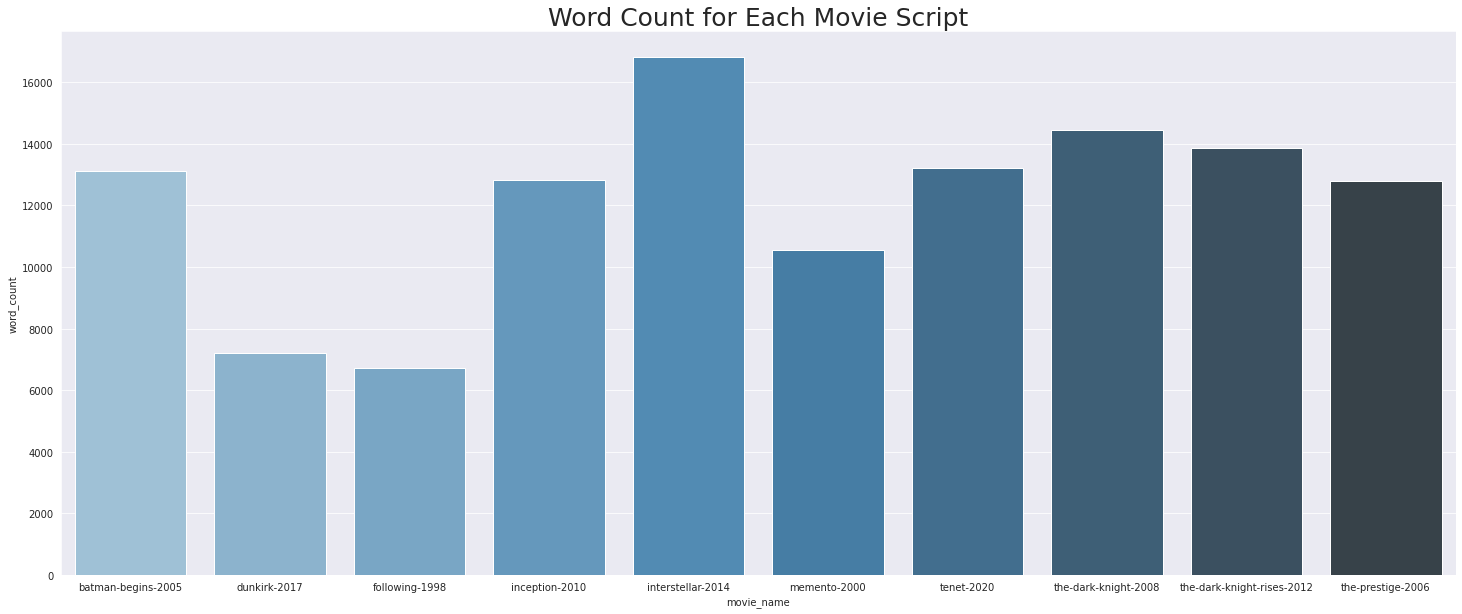

In [ ]:
plt.figure(figsize = (25, 10))
fig1 = sns.barplot(x = "movie_name", y = "word_count", data = df, palette = "Blues_d")
fig1.set_title("Word Count for Each Movie Script", fontsize = 25)
fig1.tick_params(labelsize = 10)

In [ ]:
# Get the top 20 most common words among all the scripts
def get_top_20(texts):
    p_text = texts

    # Flaten the list of lists
    p_text = [item for sublist in p_text for item in sublist]

    # Top 20
    return(pd.DataFrame(Counter(p_text).most_common(20), columns = ['word', 'frequency']))

texts = df['processed_text']
top_20_1 = get_top_20(texts)
top_20_1

word  frequency
0         wayne        826
1       leonard        766
2          cobb        689
3          turn        671
4        cooper        624
5          pull        592
6          hand        572
7          door        553
8          take        550
9        batman        528
10         open        478
11       angier        478
12  protagonist        472
13         head        453
14       gordon        431
15        young        428
16         room        420
17        watch        417
18        night        407
19       borden        393

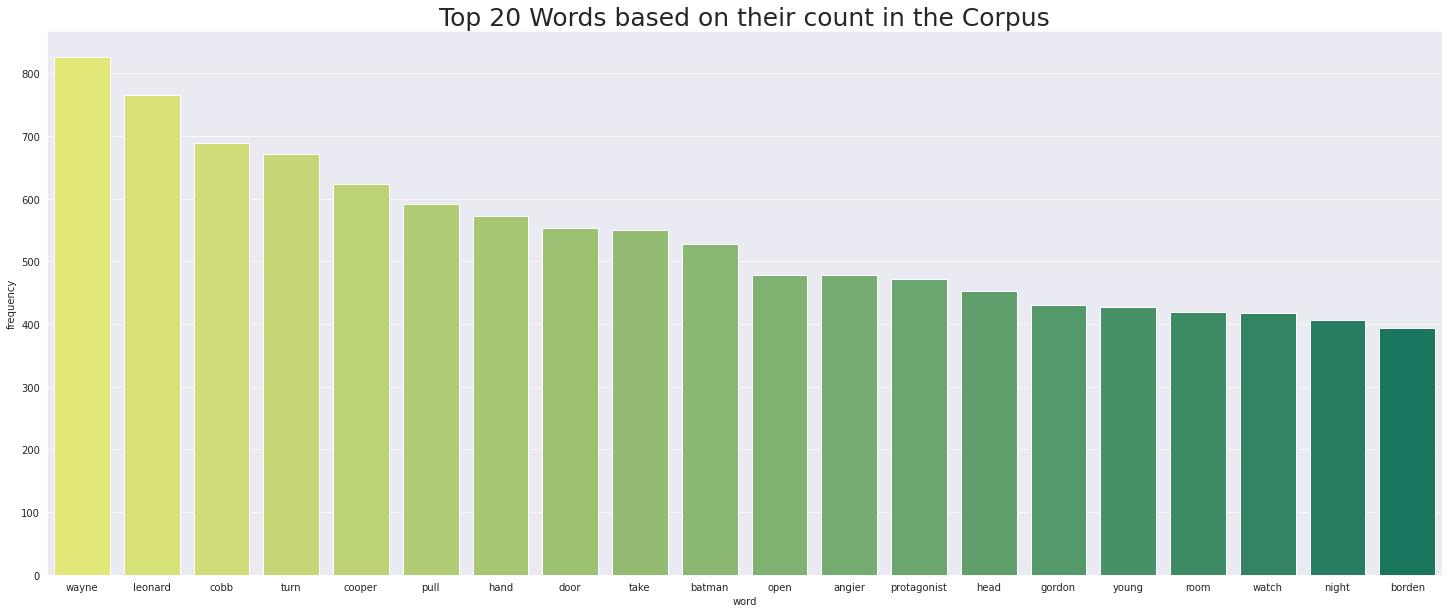

In [ ]:
# Visualization for Top 20 words
plt.figure(figsize = (25, 10))
fig2 = sns.barplot(x = "word", y = "frequency", data = top_20_1, palette = "summer_r")
fig2.set_title("Top 20 Words based on their count in the Corpus", fontsize = 25)
fig2.tick_params(labelsize = 10)

There are many character names which make of most of the topics and so the topics do not make sense. For eg, one topic only consisted names of characters from The Dark Knight trilogy and this topic only suggests that it belongs to certain movies in the franchise but nothing about the themes present. ( This interpretation is from models run previously with all those words included.) Along with character names, there are other words which individually have no ability to convey any meaning as well. So we will remove them too.

In [ ]:
# Removing character names and other frequent words
freq_words = top_20_1.word.values.tolist()
freq_words.extend(['bruce', 'rachel', 'dent', 'gotham', 'tri', 'jimmy', 'joker', 'john', 'pen', 'harvey', 'fox', 'george', 'peter',
                   'bolton', 'blonde', 'ducard', 'falcone', 'crane', 'alfred', 'robert', 'cutter', 'elevator', 'via', 'bat', 'batmobile', 
                   'martha', 'bat-pod', 'barbara', 'pov', 'thomas', 'loeb', 'mr.wayne', 'bane', 'stephen', 'lucius', 'scarecrow', 
                   'inn', 'brown', 'brand', 'farrier', 'colonel', 'winnant', 'tommy', 'gibson', 'insert', 'cut', 'ackerman', 'james', 'rachel-'])
  
def remove_freq_words(text):
    text = [w for w in text if w not in freq_words]
    return text

df['processed_text'] = df['processed_text'].apply(remove_freq_words)

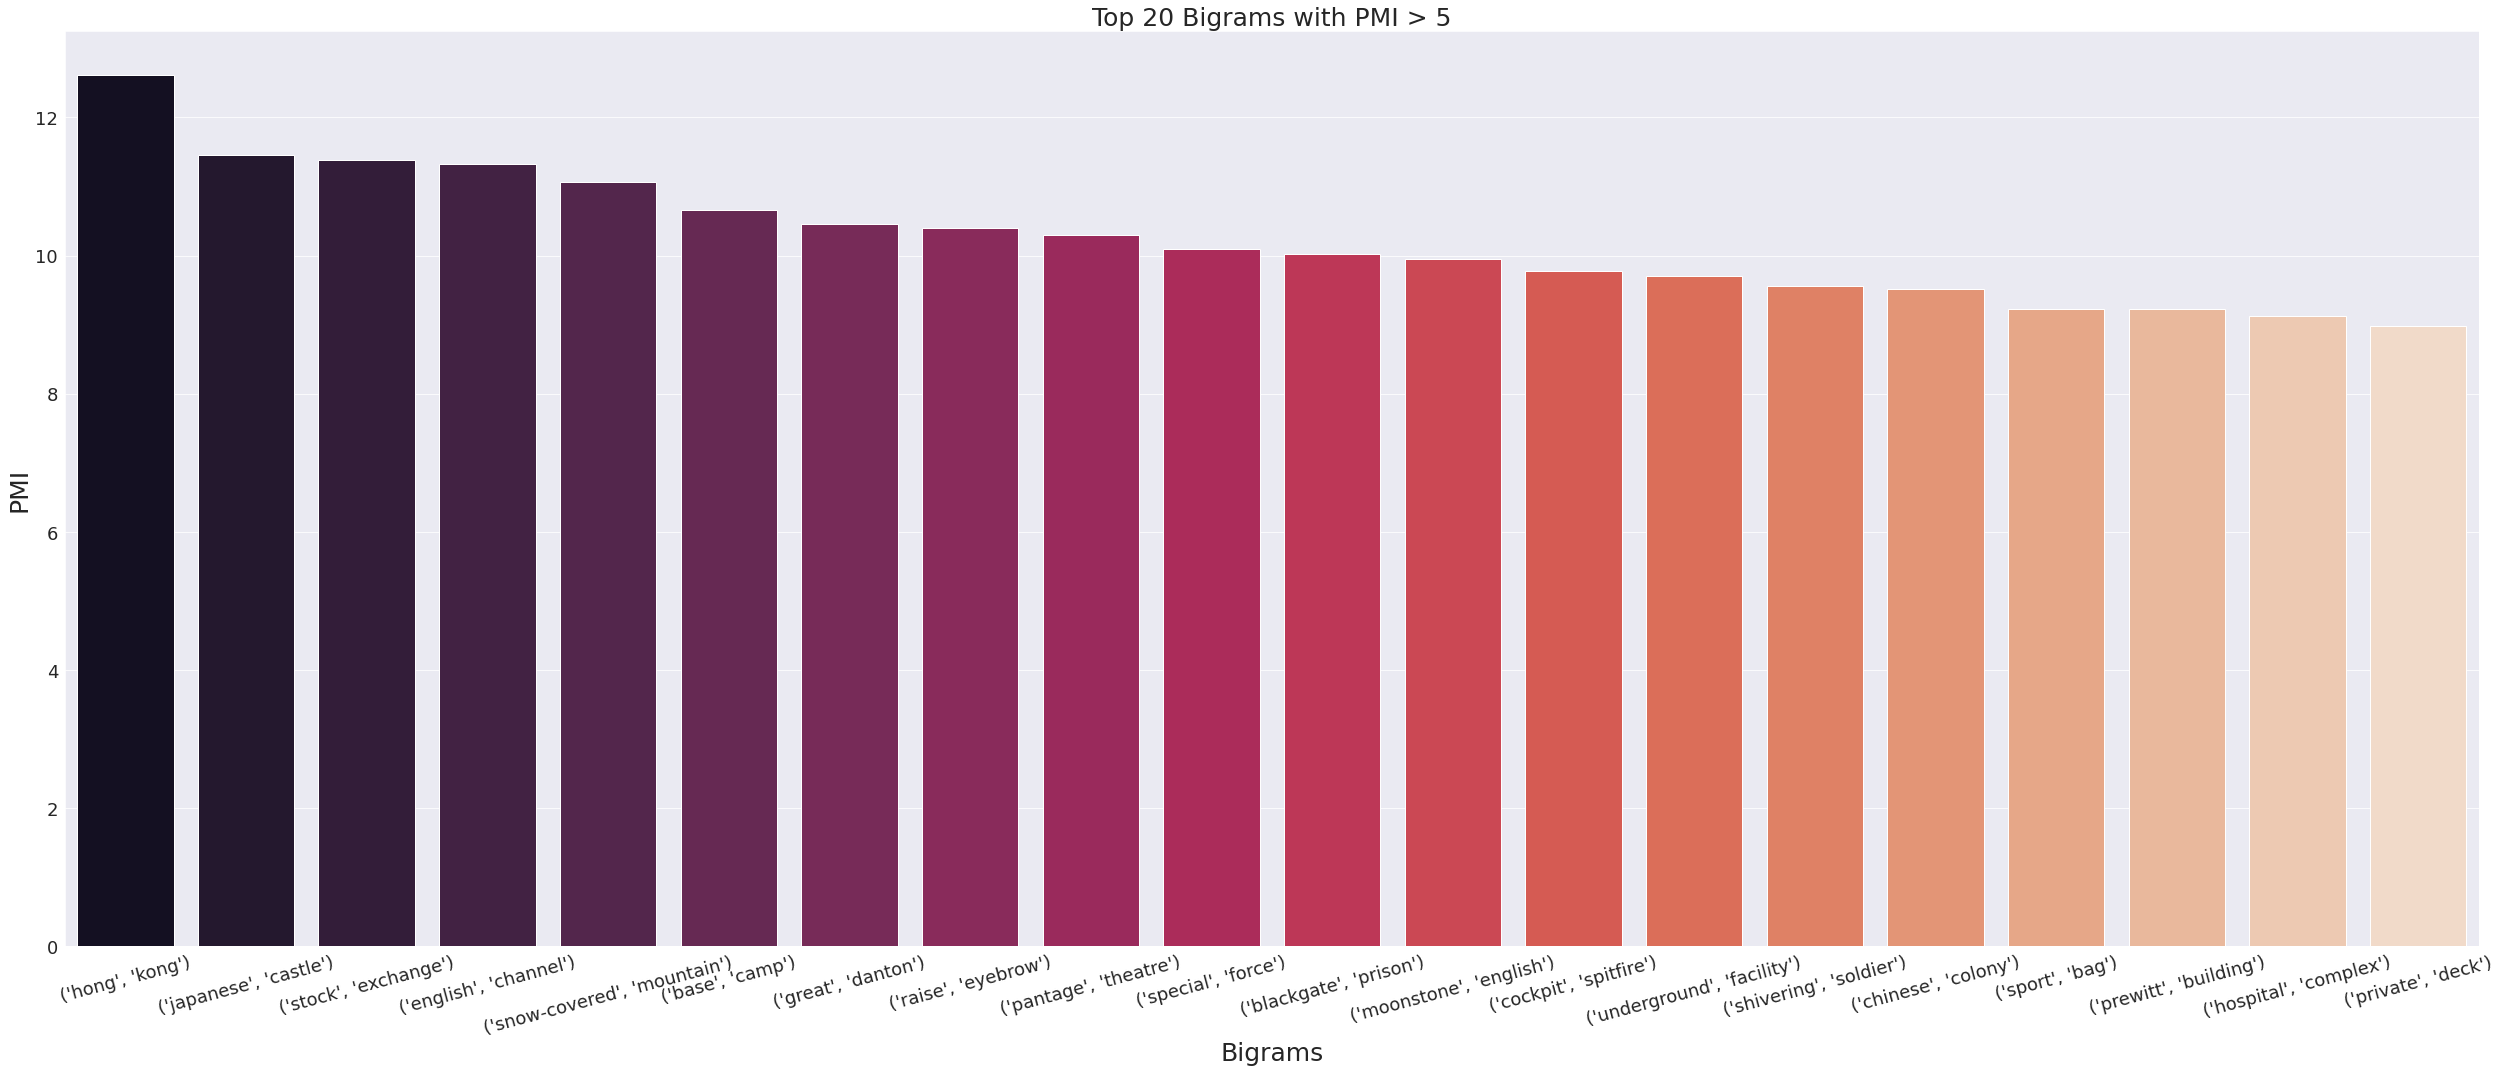

In [ ]:
# Form Bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([script for script in df.processed_text])

# Filter only those that occur at least 15 times
finder.apply_freq_filter(15)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by = 'pmi', axis = 0, ascending = False, inplace = True)

# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

# Can set Pointwise Mutual Information (PMI) threshold to whatever makes sense - eyeball through and select threshold where bigrams stop making sense
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:bigram_filter(bigram['bigram']) and bigram.pmi > 5, axis = 1)]

# Visualization for Top bigrams
plt.figure(figsize = (35, 15))
fig3 = sns.barplot(x = "bigram", y = "pmi", data = filtered_bigram[:20], palette = "rocket")
fig3.set_title("Top 20 Bigrams with PMI > 5", fontsize = 25)
fig3.set_xlabel('Bigrams', fontsize = 25)
fig3.set_ylabel('PMI', fontsize = 25)
fig3.tick_params(labelsize = 18)
plt.xticks(rotation = 15)
plt.savefig('top20-bigrams.png')
plt.tight_layout()

In [ ]:
# Concatenate Bigrams
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

def replace_bigram(x):
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x.split()

df['processed_text_w_bigrams'] = df.processed_text.apply((' ').join).apply(replace_bigram)
df

movie_name  ...                           processed_text_w_bigrams
0          batman-begins-2005  ...  [black, low, keening, becomes, screeching, bui...
1                dunkirk-2017  ...  [transferred, complete, selected, storyboards,...
2              following-1998  ...  [crowded, london, street, endless, stream, ped...
3              inception-2010  ...  [wave, toss, bearded, wet, sand, lie, child, s...
4           interstellar-2014  ...  [story, kip, thorne, lynda, obst, march, dark,...
5                memento-2000  ...  [based, short, story, short, story, ,,,,-,,,,,...
6                  tenet-2020  ...  [orchestra, tuning, audience, settling, high, ...
7        the-dark-knight-2008  ...  [final, title, story, david, goyer, created, b...
8  the-dark-knight-rises-2012  ...  [story, david, goyer, based, upon, character, ...
9           the-prestige-2006  ...  [top, hat, clustered, small, glade, super, tit...

[10 rows x 5 columns]

In [ ]:
# Word count for each script after adding bigrams
df['word_count_w_bigrams'] = df['processed_text_w_bigrams'].apply(lambda x: len(str(x).split(" ")))
df

movie_name  ... word_count_w_bigrams
0          batman-begins-2005  ...                10896
1                dunkirk-2017  ...                 6292
2              following-1998  ...                 5743
3              inception-2010  ...                11401
4           interstellar-2014  ...                15112
5                memento-2000  ...                 9046
6                  tenet-2020  ...                12002
7        the-dark-knight-2008  ...                12097
8  the-dark-knight-rises-2012  ...                11995
9           the-prestige-2006  ...                10981

[10 rows x 6 columns]

In [ ]:
# Filter words based on parts of speech tags
def imp_pos_only(x):
    pos_script = nltk.pos_tag(x)

    # To filter only nouns
    #filtered = [word[0] for word in pos_script if word[1] in ['NN']] 

    # To filter both nouns and verbs
    filtered = [word[0] for word in pos_script if word[1] in ['NN', 'VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

df['processed_text'] = df['processed_text'].apply(imp_pos_only)
texts = df['processed_text']
top_20_2 = get_top_20(texts)
top_20_2

word  frequency
0         eye        354
1       going        320
2        move        320
3         way        289
4         car        286
5        step        274
6      street        272
7        look        269
8        time        262
9   something        258
10        got        249
11       face        244
12      water        239
13      thing        230
14        gun        220
15    nothing        219
16    looking        215
17        let        215
18      start        213
19        put        210

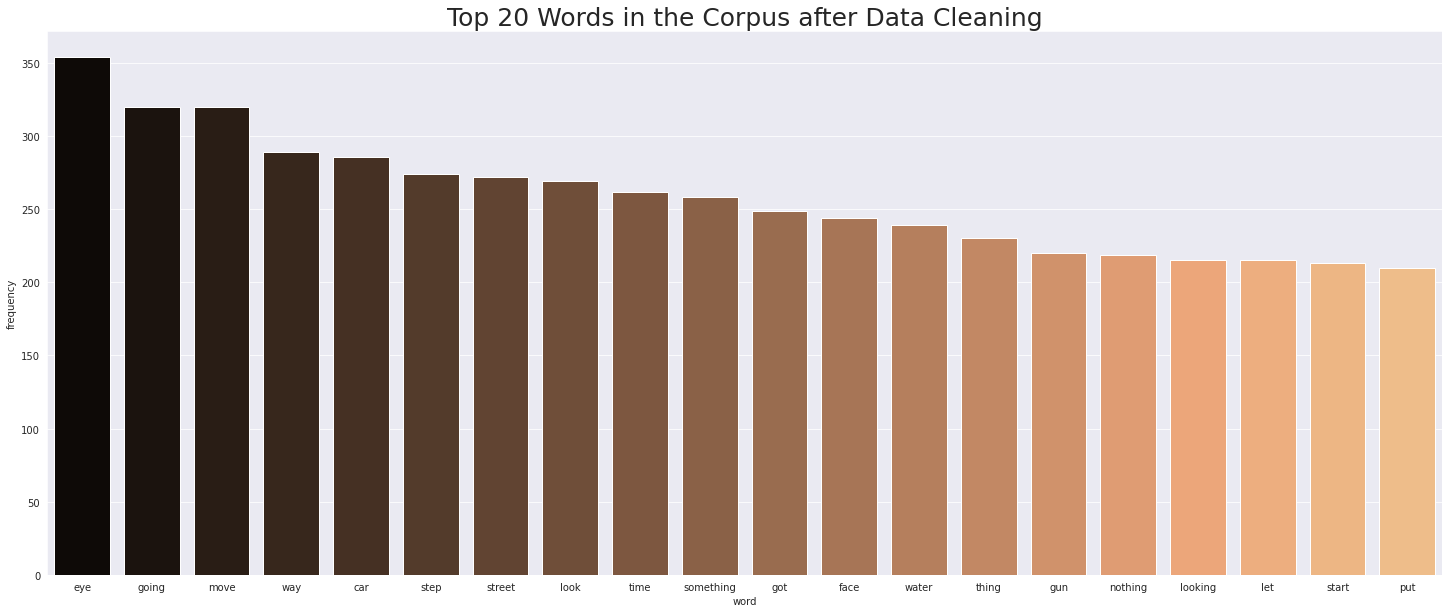

In [ ]:
# Visualization for Top 20 words after data cleaning
plt.figure(figsize = (25, 10))
fig4 = sns.barplot(x = "word", y = "frequency", data = top_20_2, palette = "copper")
fig4.set_title("Top 20 Words in the Corpus after Data Cleaning", fontsize = 25)
fig4.tick_params(labelsize = 10)
plt.savefig('top20-words-after-data-cleaning')

In [ ]:
# Get the number of unique words after processing
texts = df['processed_text_w_bigrams']
f_text = [item for sublist in texts for item in sublist]
num_unique_words = len(set(f_text))
num_unique_words

11775

### Topic Modeling using **Non - Negative Matrix Factorization (NMF)**

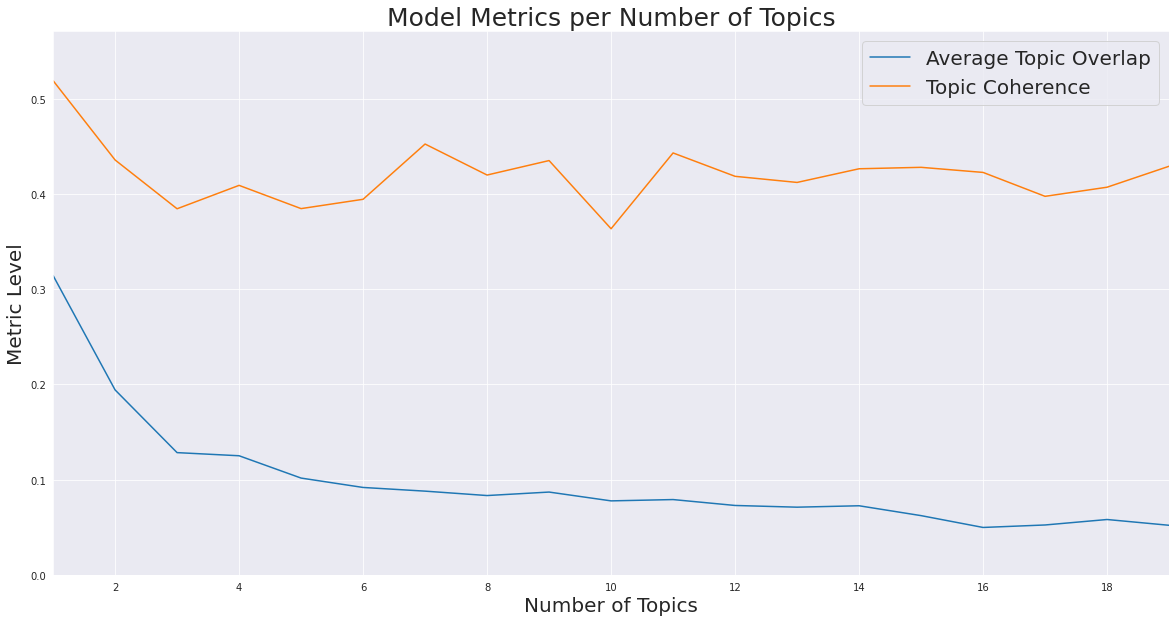

In [ ]:
# Use Gensim's NMF to get the best num of topics by finding the region/window where the gap between Coherence and Jaccard is minimum
texts = df['processed_text_w_bigrams']

# Create a dictionary
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below = 2, no_above = 0.90, keep_n = 10000)

# Create bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Calculate TF-IDF from bag of words
tfidf = models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

# Considering 2-20 topics, as the last is cut off
num_topics = list(range(21)[1:])
num_keywords = 15

NMF_models = {}
NMF_topics = {}
for i in num_topics:
    NMF_models[i] = Nmf(
                    corpus = tfidf_corpus,
                    num_topics = i,
                    id2word = dictionary,
                    chunksize = 2000,
                    passes = 5,
                    random_state = 42)

    shown_topics = NMF_models[i].show_topics(num_topics = i, num_words = num_keywords, formatted = False)
    NMF_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

# A function to derive the Jaccard similarity of two topics:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))


# Using the above to derive the mean stability across topics by considering the next topic:

NMF_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(NMF_topics[num_topics[i]]):
        sims = []
        for t2, topic2 in enumerate(NMF_topics[num_topics[i+1]]):
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    NMF_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(NMF_stability[i]).mean() for i in num_topics[:-1]]

# Calculate coherence scores
coherences = [CoherenceModel(model = NMF_models[i], texts = texts, dictionary = dictionary, coherence =  'c_v').get_coherence() for i in num_topics[:-1]]

# Finally graph these metrics across the topic numbers
plt.figure(figsize = (20, 10))
fig5 = sns.lineplot(x = num_topics[:-1], y = mean_stabilities, label = 'Average Topic Overlap')
fig5 = sns.lineplot(x = num_topics[:-1], y = coherences, label = 'Topic Coherence')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
fig5.set_ylim([0, y_max])
fig5.set_xlim([1, num_topics[-1]-1])
                
fig5.axes.set_title('Model Metrics per Number of Topics', fontsize = 25)
fig5.set_ylabel('Metric Level', fontsize = 20)
fig5.set_xlabel('Number of Topics', fontsize = 20)
plt.legend(fontsize = 20)
plt.savefig('nmf-coh-jac.jpg')
plt.show()

The window/region is considerably small for topics between 4 and 10 (might change more or less after each run) after which it starts increasing. The window is the smallest when the algorithm starts executing (before topic 4) and so it needs time to converge and thus we will not consider that gap.

After taking a look at the topics of each of the model candidates with number of topic solutions between 5 and 10, the best model suggested by the previous graph is model with 9 topics

In [ ]:
# Looking at the topics of best model
ideal_NMF_model = NMF_models[9]
pprint(ideal_NMF_model.print_topics())

[(0,
  '0.026*"theatre" + 0.020*"audience" + 0.017*"stage" + 0.017*"trick" + '
  '0.015*"workshop" + 0.011*"cage" + 0.008*"lord" + 0.008*"sullen" + '
  '0.007*"cane" + 0.007*"notebook"'),
 (1,
  '0.014*"recording" + 0.012*"vault" + 0.011*"inverted" + 0.008*"airport" + '
  '0.008*"capsule" + 0.008*"swat" + 0.007*"reverse" + 0.007*"nuclear" + '
  '0.007*"max" + 0.007*"team"'),
 (2,
  '0.025*"dream" + 0.009*"workshop" + 0.009*"van" + 0.007*"mechanism" + '
  '0.007*"duct" + 0.007*"hotel" + 0.007*"rainy" + 0.007*"security" + '
  '0.006*"bathroom" + 0.006*"sleeper"'),
 (3,
  '0.027*"mercenary" + 0.015*"prisoner" + 0.009*"sewer" + 0.009*"manor" + '
  '0.009*"cop" + 0.008*"enterprise" + 0.007*"commissioner" + 0.006*"maid" + '
  '0.006*"tunnel" + 0.006*"tumbler"'),
 (4,
  '0.022*"destroyer" + 0.016*"beach" + 0.016*"harbour" + 0.011*"boat" + '
  '0.010*"stretcher" + 0.009*"commander" + 0.009*"plane" + 0.008*"ship" + '
  '0.008*"sinking" + 0.007*"gauge"'),
 (5,
  '0.013*"cop" + 0.012*"thug" + 0.0

In [ ]:
# Coherence of the best NMF model
ideal_NMF_coh = coherences[9]
ideal_NMF_coh

0.3633760844178045

In [ ]:
# Jaccard Similarity (Mean Stability) of the best NMF model
ideal_NMF_avg_jaccard = mean_stabilities[9]
ideal_NMF_avg_jaccard

0.07762289437150537

In [ ]:
# Visualizing top 10 words and their weights in each topic 
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(ideal_NMF_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index = True)

topic_words.head()

value      word  topic
0  0.025817   theatre      0
1  0.020073  audience      0
2  0.017339     stage      0
3  0.016688     trick      0
4  0.014846  workshop      0

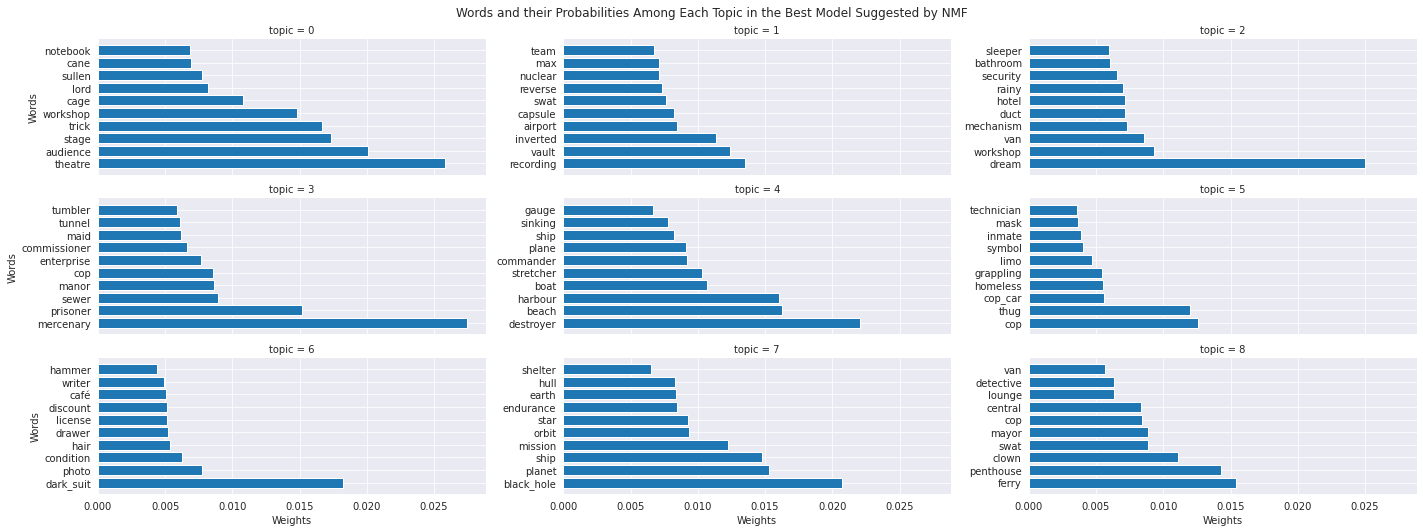

In [ ]:
fig6 = sns.FacetGrid(topic_words, col = "topic", col_wrap = 3, sharey = False, height = 2.5, aspect = 2.65)
fig6.map(plt.barh, "word", "value")
fig6.set_xlabels("Weights")
fig6.set_ylabels("Words")
fig6.fig.suptitle('Words and their Probabilities Among Each Topic in the Best Model Suggested by NMF')
plt.subplots_adjust(top = 0.92)
plt.savefig('nmf-best-9topic.jpg')
plt.show()

In [ ]:
# Finding the dominant topic in each script
def finding_dominant_topic(model, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key = lambda x: (x[1]), reverse = True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index = True)
            else:
                break

    sent_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']
    return(sent_topics_df)

sent_topics_df = finding_dominant_topic(model = ideal_NMF_model, corpus = corpus)

# Add original dataframe to topic_df
sent_topics_df = pd.concat([df, sent_topics_df], axis = 1)
sent_topics_df.reset_index(drop = True, inplace = True)
df_dominant_topic = sent_topics_df[['movie_name', 'dominant_topic', 'perc_contribution', 'topic_keywords', 'script', 'processed_text', 'word_count']]
                                   
# Show
df_dominant_topic

movie_name  ...  word_count
0          batman-begins-2005  ...       13129
1                dunkirk-2017  ...        7216
2              following-1998  ...        6723
3              inception-2010  ...       12813
4           interstellar-2014  ...       16816
5                memento-2000  ...       10544
6                  tenet-2020  ...       13220
7        the-dark-knight-2008  ...       14448
8  the-dark-knight-rises-2012  ...       13864
9           the-prestige-2006  ...       12784

[10 rows x 7 columns]

In [ ]:
# Finding topic distribution across all scripts
NMF_all_topics = ideal_NMF_model.get_document_topics(tfidf_corpus, minimum_probability = 0.0)
NMF_all_topics_csr = gensim.matutils.corpus2csc(NMF_all_topics)
NMF_all_topics_numpy = NMF_all_topics_csr.T.toarray()
topic_names = ["Topic" + str(i) for i in range(len(ideal_NMF_model.get_topics()))]
NMF_all_topics_df = pd.DataFrame(NMF_all_topics_numpy, columns = topic_names)
NMF_all_topics_df.insert(loc = 0, column = 'movie_name', value = df['movie_name'])
NMF_all_topics_df.to_csv('nmf-9topic-dist-all-docs.csv', encoding = 'utf-8', index = False)
NMF_all_topics_df

movie_name    Topic0    Topic1  ...    Topic6    Topic7    Topic8
0          batman-begins-2005  0.011499  0.016620  ...  0.012835  0.014505  0.021985
1                dunkirk-2017  0.000000  0.000000  ...  0.012880  0.043655  0.000000
2              following-1998  0.014315  0.000000  ...  0.983975  0.000000  0.000000
3              inception-2010  0.022259  0.011249  ...  0.014263  0.009112  0.030745
4           interstellar-2014  0.008407  0.000000  ...  0.004169  0.930127  0.014613
5                memento-2000  0.000000  0.012082  ...  0.794227  0.012789  0.014692
6                  tenet-2020  0.033026  0.889032  ...  0.000000  0.020556  0.000000
7        the-dark-knight-2008  0.000000  0.028459  ...  0.016095  0.000000  0.758458
8  the-dark-knight-rises-2012  0.000000  0.033257  ...  0.000000  0.000000  0.000000
9           the-prestige-2006  0.943350  0.000000  ...  0.014757  0.008365  0.005428

[10 rows x 10 columns]

### Topic Modeling using **Latent Dirichlet Allocation (LDA)**

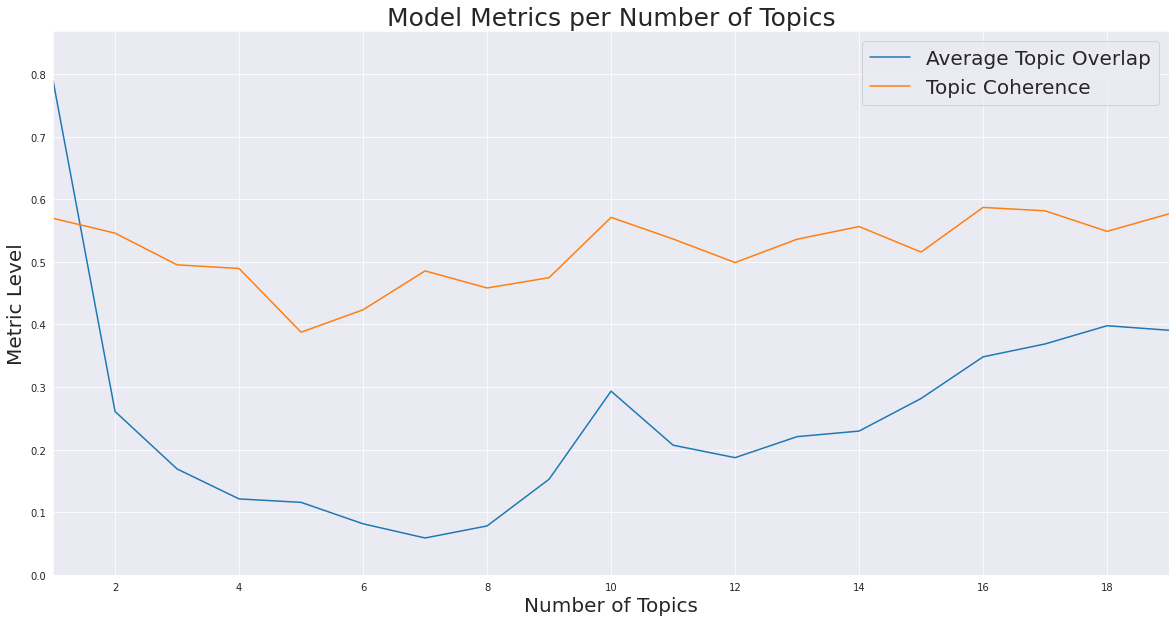

In [ ]:
# Use Gensim's LDA to get the best num of topics via maximising coherence score and minimising jaccard similarity
texts = df['processed_text_w_bigrams']

# Create a dictionary
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below = 2, no_above = 0.90, keep_n = 10000)

# Create bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Calculate TF-IDF from bag of words
tfidf = models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

# Considering 2-20 topics, as the last is cut off
num_topics = list(range(21)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(
                    corpus = tfidf_corpus,
                    id2word = dictionary,
                    num_topics = i,
                    update_every = 1,
                    chunksize = 2000,
                    passes = 20,
                    iterations = 200,
                    alpha = 'auto',
                    random_state = 42)

    shown_topics = LDA_models[i].show_topics(num_topics = i, num_words = num_keywords, formatted = False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

# Using the jaccard similarity function to derive the mean stability across topics by considering the next topic:

LDA_stability = {}
for i in range(0, len(num_topics) - 1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]):
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i + 1]]):
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

# Calculate coherence scores
coherences = [CoherenceModel(model = LDA_models[i], texts = texts, dictionary = dictionary, coherence =  'c_v').get_coherence() for i in num_topics[:-1]]

# Finally graph these metrics across the topic numbers
plt.figure(figsize = (20, 10))
fig7 = sns.lineplot(x = num_topics[:-1], y = mean_stabilities, label = 'Average Topic Overlap')
fig7 = sns.lineplot(x = num_topics[:-1], y = coherences, label = 'Topic Coherence')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
fig7.set_ylim([0, y_max])
fig7.set_xlim([1, num_topics[-1]-1])
                
fig7.axes.set_title('Model Metrics per Number of Topics', fontsize = 25)
fig7.set_ylabel('Metric Level', fontsize = 20)
fig7.set_xlabel('Number of Topics', fontsize = 20)
plt.legend(fontsize = 20)
plt.savefig('lda-coh-jac.jpg')
plt.show()

The window/region is considerably small for topics between 5 and 10 (might change more or less after each run) after which it starts decreasing but the topics make no sense. The window is the smallest when the algorithm starts executing (before topic 5) and so it needs time to converge and thus we will not consider that gap.

After taking a look at the topics of each of the model candidates with number of topic solutions between 5 and 10, the best model suggested by the previous graph is model with 7 topics.

In [ ]:
# Looking at the topics of the best LDA model suggested by the previous graph
ideal_LDA_model = LDA_models[7]
pprint(ideal_LDA_model.print_topics())

[(0,
  '0.001*"theatre" + 0.001*"audience" + 0.001*"stage" + 0.001*"trick" + '
  '0.001*"workshop" + 0.000*"cage" + 0.000*"lord" + 0.000*"sullen" + '
  '0.000*"cane" + 0.000*"notebook"'),
 (1,
  '0.001*"dream" + 0.001*"workshop" + 0.000*"van" + 0.000*"mechanism" + '
  '0.000*"hotel" + 0.000*"rainy" + 0.000*"duct" + 0.000*"security" + '
  '0.000*"bathroom" + 0.000*"sleeper"'),
 (2,
  '0.000*"dark_suit" + 0.000*"theatre" + 0.000*"thug" + 0.000*"mercenary" + '
  '0.000*"destroyer" + 0.000*"ship" + 0.000*"cop" + 0.000*"beach" + '
  '0.000*"tired" + 0.000*"tortured"'),
 (3,
  '0.001*"recording" + 0.001*"vault" + 0.001*"inverted" + 0.000*"airport" + '
  '0.000*"capsule" + 0.000*"swat" + 0.000*"reverse" + 0.000*"yacht" + '
  '0.000*"nuclear" + 0.000*"max"'),
 (4,
  '0.001*"destroyer" + 0.001*"beach" + 0.001*"harbour" + 0.000*"ship" + '
  '0.000*"stretcher" + 0.000*"boat" + 0.000*"commander" + 0.000*"plane" + '
  '0.000*"sinking" + 0.000*"gauge"'),
 (5,
  '0.001*"cop" + 0.001*"mercenary" + 0.0

In [ ]:
# Coherence of the best LDA model
ideal_LDA_coh = coherences[7]
ideal_LDA_coh

0.4582179485103317

In [ ]:
# Jaccard Similarity (Mean Stability) of the best LDA model
ideal_LDA_avg_jaccard = mean_stabilities[7]
ideal_LDA_avg_jaccard

0.07805870162192002

In [ ]:
# Compute Perplexity; a measure of how good the model is; lower the better
ideal_LDA_perp = ideal_LDA_model.log_perplexity(corpus)
print('\nPerplexity of LDA model: ', ideal_LDA_perp)


Perplexity of LDA model:  -12.800877411178098


In [ ]:
# Visualizing top 10 words and their weights in each topic
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(ideal_LDA_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index = True)

topic_words.head()

value      word  topic
0  0.000796   theatre      0
1  0.000662  audience      0
2  0.000602     stage      0
3  0.000586     trick      0
4  0.000547  workshop      0

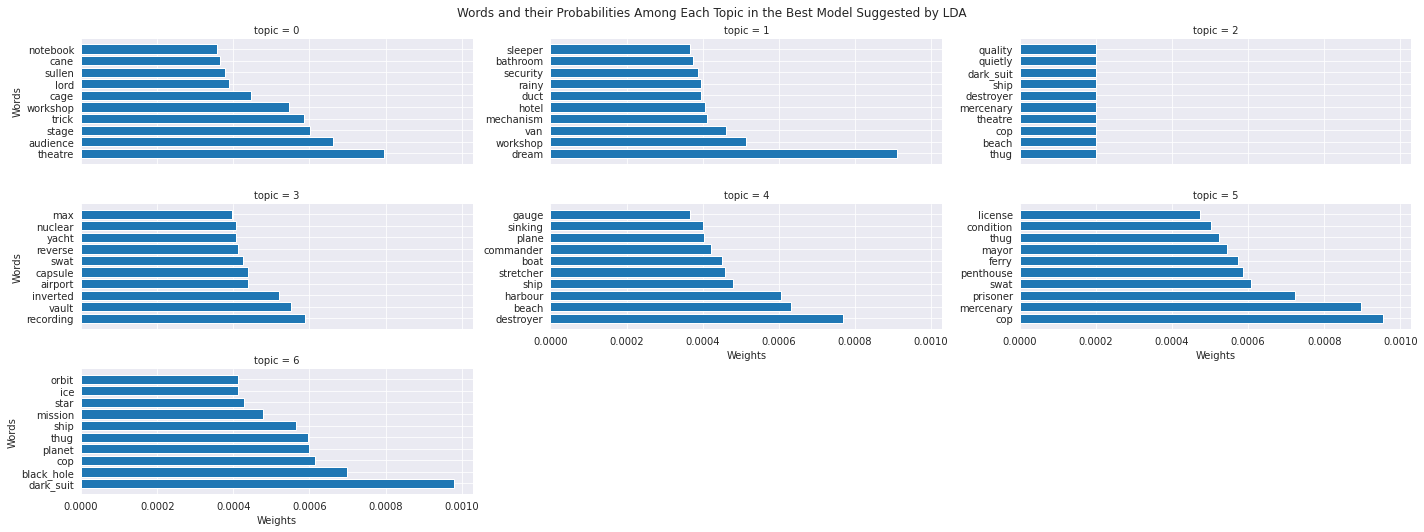

In [ ]:
fig8 = sns.FacetGrid(topic_words, col = "topic", col_wrap = 3, sharey = False, height = 2.5, aspect = 2.65)
fig8.map(plt.barh, "word", "value")
fig8.set_xlabels("Weights")
fig8.set_ylabels("Words")
fig8.fig.suptitle('Words and their Probabilities Among Each Topic in the Best Model Suggested by LDA')
plt.subplots_adjust(top = 0.92)
plt.savefig('lda-best-7topic.jpg')
plt.show()

In [ ]:
# Interactive visualisation for topics of the best LDA model
pyLDAvis.enable_notebook()
fig9 = pyLDAvis.gensim_models.prepare(ideal_LDA_model, corpus, dictionary, mds = 'mmds')
plt.savefig('lda-7topic-ldavis')
fig9

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.000702 -0.002208       1        1  38.925461
6     -0.001694  0.000929       2        1  31.136456
0      0.000852  0.000725       3        1   8.625906
3      0.001200 -0.000009       4        1   8.132214
1      0.000418  0.000261       5        1   7.584669
4     -0.000185 -0.000122       6        1   5.594977
2      0.000110  0.000424       7        1   0.000316, topic_info=           Term       Freq      Total Category  logprob  loglift
1354  mercenary  26.000000  26.000000  Default   30.000  30.0000
3035  dark_suit  24.000000  24.000000  Default   29.000  29.0000
447         cop  35.000000  35.000000  Default   28.000  28.0000
1615   prisoner  23.000000  23.000000  Default   27.000  27.0000
2130       swat  22.000000  22.000000  Default   26.000  26.0000
...         ...        ...        ...      ...      ...      ...
17      adjusts   0.000036  11.031322   Topic7   -8.511   0.0271
18     admiring   0.000036  10.958090   Topic7   -8.511   0.0337
19      advance   0.000036  11.497764   Topic7   -8.511  -0.0143
20     advanced   0.000036  11.102874   Topic7   -8.511   0.0206
21       advice   0.000036  11.512120   Topic7   -8.511  -0.0156

[299 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.353126   -and
0         2  0.353126   -and
0         3  0.088282   -and
0         4  0.088282   -and
0         5  0.088282   -and
...     ...       ...    ...
2923      2  0.242584  yacht
2923      3  0.080861  yacht
2923      4  0.161723  yacht
2923      5  0.080861  yacht
2923      6  0.080861  yacht

[1494 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 1, 4, 2, 5, 3])

<Figure size 432x288 with 0 Axes>

In [ ]:
# Finding the dominant topic in each script
sent_topics_df = finding_dominant_topic(model = ideal_LDA_model, corpus = corpus)

# Add original dataframe to topic_df
sent_topics_df = pd.concat([df, sent_topics_df], axis = 1)
sent_topics_df.reset_index(drop = True, inplace = True)
df_dominant_topic = sent_topics_df[['movie_name', 'dominant_topic', 'perc_contribution', 'topic_keywords', 'script', 'processed_text', 'word_count']]
                                   
# Show
df_dominant_topic

movie_name  ...  word_count
0          batman-begins-2005  ...       13129
1                dunkirk-2017  ...        7216
2              following-1998  ...        6723
3              inception-2010  ...       12813
4           interstellar-2014  ...       16816
5                memento-2000  ...       10544
6                  tenet-2020  ...       13220
7        the-dark-knight-2008  ...       14448
8  the-dark-knight-rises-2012  ...       13864
9           the-prestige-2006  ...       12784

[10 rows x 7 columns]

In [ ]:
# Finding topic distribution across all scripts
LDA_all_topics = ideal_LDA_model.get_document_topics(tfidf_corpus, minimum_probability = 0.0)
LDA_all_topics_csr = gensim.matutils.corpus2csc(LDA_all_topics)
LDA_all_topics_numpy = LDA_all_topics_csr.T.toarray()
topic_names = ["Topic" + str(i) for i in range(len(ideal_LDA_model.get_topics()))]
LDA_all_topics_df = pd.DataFrame(LDA_all_topics_numpy, columns = topic_names)
LDA_all_topics_df.insert(loc = 0, column = 'movie_name', value = df['movie_name'])
LDA_all_topics_df.to_csv('lda-7topic-dist-all-docs.csv', encoding = 'utf-8', index = False)
LDA_all_topics_df

movie_name    Topic0    Topic1  ...    Topic4    Topic5    Topic6
0          batman-begins-2005  0.000900  0.000904  ...  0.000898  0.001852  0.993985
1                dunkirk-2017  0.001693  0.001700  ...  0.986893  0.003484  0.003483
2              following-1998  0.001531  0.001537  ...  0.001528  0.003150  0.989769
3              inception-2010  0.001217  0.990584  ...  0.001215  0.002505  0.002504
4           interstellar-2014  0.001329  0.001335  ...  0.001327  0.002735  0.991116
5                memento-2000  0.001296  0.001301  ...  0.001293  0.991341  0.002666
6                  tenet-2020  0.001176  0.001181  ...  0.001174  0.002420  0.002419
7        the-dark-knight-2008  0.001105  0.001109  ...  0.001103  0.992617  0.002273
8  the-dark-knight-rises-2012  0.001259  0.001264  ...  0.001256  0.991587  0.002590
9           the-prestige-2006  0.988318  0.001516  ...  0.001506  0.003106  0.003105

[10 rows x 8 columns]

## Topic Modeling using Biterm (BTM)

In [ ]:
texts = df['processed_text_w_bigrams']
texts = [(' ').join(sublist) for sublist in texts]

stop_words.extend(freq_words)

In [ ]:
# Preprocessing
# Obtaining terms frequency in a sparse matrix and corpus vocabulary
X, vocabulary, vocab_dict = btm.get_words_freqs(texts, stop_words = stop_words)
tf = np.array(X.sum(axis = 0)).ravel()

# Vectorizing documents
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
docs_lens = list(map(len, docs_vec))

# Generating biterms
biterms = btm.get_biterms(docs_vec)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['interstellar_d', 'million', 'mrs', 'pod', 'prestige', 'scw'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
# Initialising and running the model

# Considering 2-20 topics, as the last is cut off
num_topics = list(range(21)[1:])
num_keywords = 15

BTM_models = {}
coherence_list = []
for i in num_topics:
    BTM_models[i] = btm.BTM(X, vocabulary, seed = 12321, T = i, M = num_keywords)
    BTM_models[i].fit(biterms, iterations = 20)
    p_zd =  BTM_models[i].transform(docs_vec)
    coherence = btm.coherence(BTM_models[i].matrix_topics_words_, X, M = num_keywords)
    coherence_list.append(coherence)

# Finally graph these metrics across the topic numbers
coherence_list = list(map(np.mean, coherence_list))

100%|██████████| 10/10 [00:00<00:00, 48.53it/s]


In [ ]:
# Taking the model with 5 topic solution as the ideal one; index starts at 0
ideal_BTM_coh = coherence_list[4]
ideal_BTM_coh

7.671908616626757

In [ ]:
# Perplexity
ideal_BTM_model = BTM_models[5]
ideal_BTM_perp = ideal_BTM_model.perplexity_
print("Perplexity of BTM Model", ideal_BTM_perp)

Perplexity of BTM Model 1160.0934542848142


In [ ]:
# Top 15 words in each topic of the best BTM model
btm_topics_df = btm.get_top_topic_words(ideal_BTM_model, words_num = 15, topics_idx = [0,1,2,3,4])
btm_topics_df.to_csv('btm-topics-df.csv', encoding = 'utf-8', index = False)
btm_topics_df

topic0     topic1   topic2   topic3 topic4
0    arthur       ship    teddy    water    kat
1   fischer       case    think     fire   thug
2     saito      begin     want    truck   step
3   ariadne      murph  natalie   street   neil
4      move      stage    would  towards  table
5     eames      light    thing      gun   move
6       mal      doyle    smile      car  blake
7       eye    machine      got   behind   walk
8       gun       roth     need   across   look
9      face       time     look     away  sator
10     come      probe      say     grab    bag
11   window    control    going    plane  reach
12   street  something    sammy    start    gun
13    start   wormhole     make     come  smile
14      nod       step   people     neil   away

In [ ]:
# Run the interactive report interface
tmp.report(model = ideal_BTM_model, docs = texts)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


## Topic Models Comparison

In [ ]:
# Creating a dataframe to compare metrics of best models suggested by LDA, NMF and BTM

metrics_data = [['LDA 7-Topic Model', 'Coherence', ideal_LDA_coh],
                ['LDA 7-Topic Model', 'Average Topic Overlap (Jaccard Similarity)', ideal_LDA_avg_jaccard],
                ['LDA 7-Topic Model', 'Perplexity', ideal_LDA_perp],
                ['NMF 9-Topic Model', 'Coherence', ideal_NMF_coh],
                ['NMF 9-Topic Model', 'Average Topic Overlap (Jaccard Similarity)', ideal_NMF_avg_jaccard],
                ['NMF 9-Topic Model', 'Perplexity', np.NaN], 
                ['BTM 4-Topic Model', 'Coherence', ideal_BTM_coh],
                ['BTM 4-Topic Model', 'Average Topic Overlap (Jaccard Similarity)', np.NaN],
                ['BTM 4-Topic Model', 'Perplexity', ideal_BTM_perp]]

metrics_df = pd.DataFrame(metrics_data, columns = ['Best Topic Model', 'Metric', 'Value'])
metrics_df

Best Topic Model                                      Metric        Value
0  LDA 7-Topic Model                                   Coherence     0.458218
1  LDA 7-Topic Model  Average Topic Overlap (Jaccard Similarity)     0.078059
2  LDA 7-Topic Model                                  Perplexity   -12.800877
3  NMF 9-Topic Model                                   Coherence     0.363376
4  NMF 9-Topic Model  Average Topic Overlap (Jaccard Similarity)     0.077623
5  NMF 9-Topic Model                                  Perplexity          NaN
6  BTM 4-Topic Model                                   Coherence     7.671909
7  BTM 4-Topic Model  Average Topic Overlap (Jaccard Similarity)          NaN
8  BTM 4-Topic Model                                  Perplexity  1160.093454

In [ ]:
metrics_df.pivot(index = 'Best Topic Model', columns = 'Metric', values = 'Value')

Metric             Average Topic Overlap (Jaccard Similarity)  ...   Perplexity
Best Topic Model                                               ...             
BTM 4-Topic Model                                         NaN  ...  1160.093454
LDA 7-Topic Model                                    0.078059  ...   -12.800877
NMF 9-Topic Model                                    0.077623  ...          NaN

[3 rows x 3 columns]

Best LDA model has a higher coherence than the best NMF model while their differences in average topic overlap is negligible. Based on judgement, NMF's topic solutions look the most optimal among all other algorithms for the movie script dataset.

Topic Labels and keywords for best topic solution provided by NMF:

1.	Deception: theatre, audience, stage, trick, workshop
2.	Reversed Movement: recording, vault, inverted, airport, capsule
3.	Strange Dreams: Dream, workshop, van, mechanism, duct
4.	Terrorism: Mercenary, prisoner, sewer, manor, cop, commissioner
5.	Sea Warfare: destroyer, beach, harbour, boat, stretcher, commander
6.	Crime: cop, thug, cop_car, homeless, symbol,  inmate
7.	Random: dark_suit, photo, condition, hair, drawer
8.	Space: black_hole, planet, ship, mission, orbit, star
9.	Crime Mystery: ferry, penthouse, clown, swat, mayor, cop, detective